# Python imports

In [19]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tslearn.utils import to_time_series_dataset
import ray

# Import final dataframe

In [2]:
final_df = pd.read_csv("final_df.csv", index_col=0)
final_df_wona = final_df.dropna(axis=1)
normalized_final_df = (final_df_wona - final_df_wona.mean()) / final_df_wona.std()

# Convert to `tslearn` dataset

In [3]:
X_train = to_time_series_dataset(normalized_final_df.T)
X_train.shape # n_ts, max_sz, d

(517, 240, 1)

# Elbow curve on silouhette score

In [4]:
ray.init(ignore_reinit_error=True, num_cpus=6)

2023-09-12 08:14:49,435	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.6.3


In [14]:
distance_matrix = cdist_dtw(X_train)

@ray.remote
def get_ts_k_means(cluster_count):
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw",
                          n_init=1, n_jobs=2,
                          metric_params={"sakoe_chiba_radius": 10,
                                         "global_constraint": "sakoe_chiba"})
    labels = km.fit_predict(X_train)
    score = silhouette_score(distance_matrix, labels, metric="precomputed")
    return cluster_count, score


(pid=11922) /home/clem/Documents/source/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
(pid=11922) Install h5py to use hdf5 features: http://docs.h5py.org/
(pid=11922)   warn(h5py_msg)


([<matplotlib.axis.XTick at 0x7ff95c2e2df0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

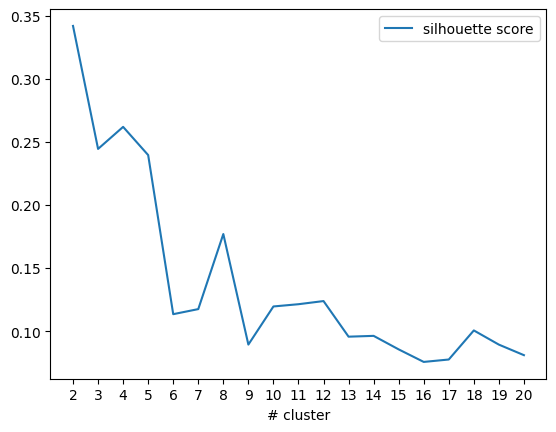

In [15]:
max_cluster_count = 21
scores = []

object_references = [get_ts_k_means.remote(cluster_count) for cluster_count in range(2, max_cluster_count)]

while len(object_references) > 0:
    finished, object_references = ray.wait(object_references, num_returns=1)
    score = ray.get(finished)
    scores.extend(score)

pd.DataFrame(scores).rename(
        columns={0:"# cluster", 1:"silhouette score"}
    ).sort_values(
        "# cluster"
    ).plot(x="# cluster", y="silhouette score")

plt.xticks(range(2, max_cluster_count))

# Choosing the cluster count

In [16]:
CLUSTER_COUNT = 9
km = TimeSeriesKMeans(n_clusters=CLUSTER_COUNT, metric="dtw",
                      n_jobs=2, n_init=5,
                      metric_params={"sakoe_chiba_radius": 10,
                                     "global_constraint": "sakoe_chiba"})

labels = km.fit_predict(X_train)

silhouettes_scores = silhouette_samples(distance_matrix, labels, metric="precomputed")

# Analyzing the redundant tokens in the time serie names of cluster

In [67]:
from tsclustering.text_processing import (parse_serie_name, get_dict_count,
                                          get_dict_freq, get_doc_dicts, 
                                          get_idf_scores, get_tfidf_scores)

In [68]:
# { i: column_name for i, column_name in enumerate(normalized_final_df.columns) }
# cluster_serie_indices = np.where(labels == i)[0]

column_names = np.array(normalized_final_df.columns)

cluster_sizes = []
names_by_cluster = []
series_by_cluster = []
cluster_tokens = []
corpus_unique_tokens = set()

for i in range(CLUSTER_COUNT):
    cluster_series = X_train[labels == i]
    series_by_cluster.append(cluster_series)

    cluster_serie_names = column_names[labels == i]
    names_by_cluster.append(cluster_serie_names)

    cluster_size = len(cluster_series)
    cluster_sizes.append(cluster_size)

    tokens = sum([parse_serie_name(serie_name) for serie_name in cluster_serie_names],[])
    cluster_tokens.append(tokens)
    corpus_unique_tokens.update(set(tokens))


## Corpus Dict

In [69]:
corpus_tokens = sum(cluster_tokens,[])
corpus_dict = get_dict_count(corpus_tokens)
list(corpus_dict.items())[:10]

[('Défaillances', 296),
 ('Unités légales', 296),
 ('nombre cumulé sur 12 mois', 279),
 ('Indice de ventes au détail', 56),
 ('Indice de production industrielle', 56),
 ('Valeur nominale', 35),
 ('Taux de chômage', 29),
 ('Sociétés non financières', 21),
 ('Valeur de marché', 20),
 ('Cumul mensuel', 17)]

## TFIDF scores

In [70]:
# idf
cluster_dicts = get_doc_dicts(cluster_tokens)
idf_scores = get_idf_scores(corpus_unique_tokens, cluster_dicts)

cluster_tdidfs = []

# tf-idf
for tokens in cluster_tokens:
    cluster_dict_counts = get_dict_count(tokens)
    cluster_dict_freqs = get_dict_freq(cluster_dict_counts)

    tfidf_scores = get_tfidf_scores(cluster_dict_freqs, idf_scores)
    cluster_tdidfs.append(tfidf_scores)

## Filtering common tokens

In [71]:
def filter_common_tokens(token_freqs_by_cluster: dict, common_words):
    filtered_tokens = []
    filter_freqs = []

    for token_freqs in token_freqs_by_cluster:
        filter_freqs_by_cluster = {}
        for token, freq in token_freqs.items():
            if sum([common_word in token for common_word in common_words]) > 0:
                filtered_tokens.append(token)
                continue
            filter_freqs_by_cluster[token] = freq
        
        filter_freqs.append(filter_freqs_by_cluster)
    
    return filter_freqs, set(filtered_tokens)

common_words = ["mois", "annuel", "mensuel", "Défaillances", "Unités légales", 
                "Indice de production industrielle",
                "Indice de ventes au détail"]

token_freqs_by_cluster = [get_dict_count(tokens) for tokens in cluster_tokens]
filter_token_freqs_by_cluster, filtered_tokens = filter_common_tokens(token_freqs_by_cluster, common_words)

filter_token_tfidfs_by_cluster, filtered_tokens = filter_common_tokens(cluster_tdidfs, common_words)

## Get most frequent tokens by time serie names cluster

In [72]:
import math

def get_k_first_item(freq_dict, k):
    i = 0
    for key, value in freq_dict.items():
        i+=1
        yield f"{key} ({round(value, 2)})"
        if i > k:
            break

In [83]:
df_freq = pd.DataFrame({
    "cluster": range(1, len(cluster_sizes)+1),
    "size":cluster_sizes,
    "series":[", ".join(get_k_first_item(token_freqs,5)) for token_freqs in filter_token_freqs_by_cluster]
})

print(df_freq.reset_index(drop=True).set_index(["cluster"]).to_markdown())

|   cluster |   size | series                                                                                                                                                                              |
|----------:|-------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|         1 |     56 | Taux de chômage (10), Construction (9), Commerce et réparation automobile (4), Provence-Alpes-Cote d`Azur (3), Luxembourg (2), Bourgogne-Franche-Comté (2)                          |
|         2 |     29 | Information et communication (13), Activités financières et d'assurance (3), Bourgogne-Franche-Comté (2), Hauts-de-France (2), Ile-de-France (2), Grand Est (2)                     |
|         3 |     41 | Espagne (4), Grèce (4), Valeur de marché (3), Italie (3), Autres institutions financières monétaires (2), Valeur nominale (2)                                

In [82]:
df_tfidf = pd.DataFrame({
    "cluster": range(1, len(cluster_sizes)+1),
    "size":cluster_sizes,
    "series":[", ".join(get_k_first_item(tfidfs,5)) for tfidfs in filter_token_tfidfs_by_cluster]
})

print(df_tfidf.reset_index(drop=True).set_index(["cluster"]).to_markdown())

|   cluster |   size | series                                                                                                                                                                                                             |
|----------:|-------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|         1 |     56 | Taux de chômage (0.1), Construction (0.06), Provence-Alpes-Cote d`Azur (0.03), Luxembourg (0.02), Bourgogne-Franche-Comté (0.02), Soutien aux entreprises (0.02)                                                   |
|         2 |     29 | Information et communication (0.23), Bourgogne-Franche-Comté (0.04), Hauts-de-France (0.04), Grand Est (0.04), Ensemble des départements d`Outre-Mer (0.04), Danemark (0.02)                                       |
|         3 |     41 | Espagne (0.09), Valeur de marché 

In [75]:
for names in names_by_cluster:
    print(names)

['Encours notionnels de titres de dette à court terme, Autres institutions financières monétaires, Valeur nominale'
 'Emissions nettes de titres de dette des administrations publiques, Cumul annuel'
 'Danemark, Taux de chômage (CVS)' 'Royaume-Uni, Taux de chômage (CVS)'
 'Hongrie, Taux de chômage (CVS)'
 'Luxembourg, Indice de ventes au détail (CJO)'
 'Luxembourg, Indice de ventes au détail (CVS-CJO)'
 'Suède, Taux de chômage (CVS)' 'Etats-Unis, Taux de chômage (CVS)'
 'Irlande, Taux de chômage (CVS)' 'Portugal, Taux de chômage (CVS)'
 'Slovénie, Taux de chômage (CVS)' 'Pays-Bas, Taux de chômage (CVS)'
 'Zone euro, Taux de chômage (CVS)'
 'Défaillances, Construction, Bourgogne-Franche-Comté, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Aisne, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Hautes-Alpes, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Alpes-Maritimes, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Aude, Unités légales, nom

# Plotting a summary diagram

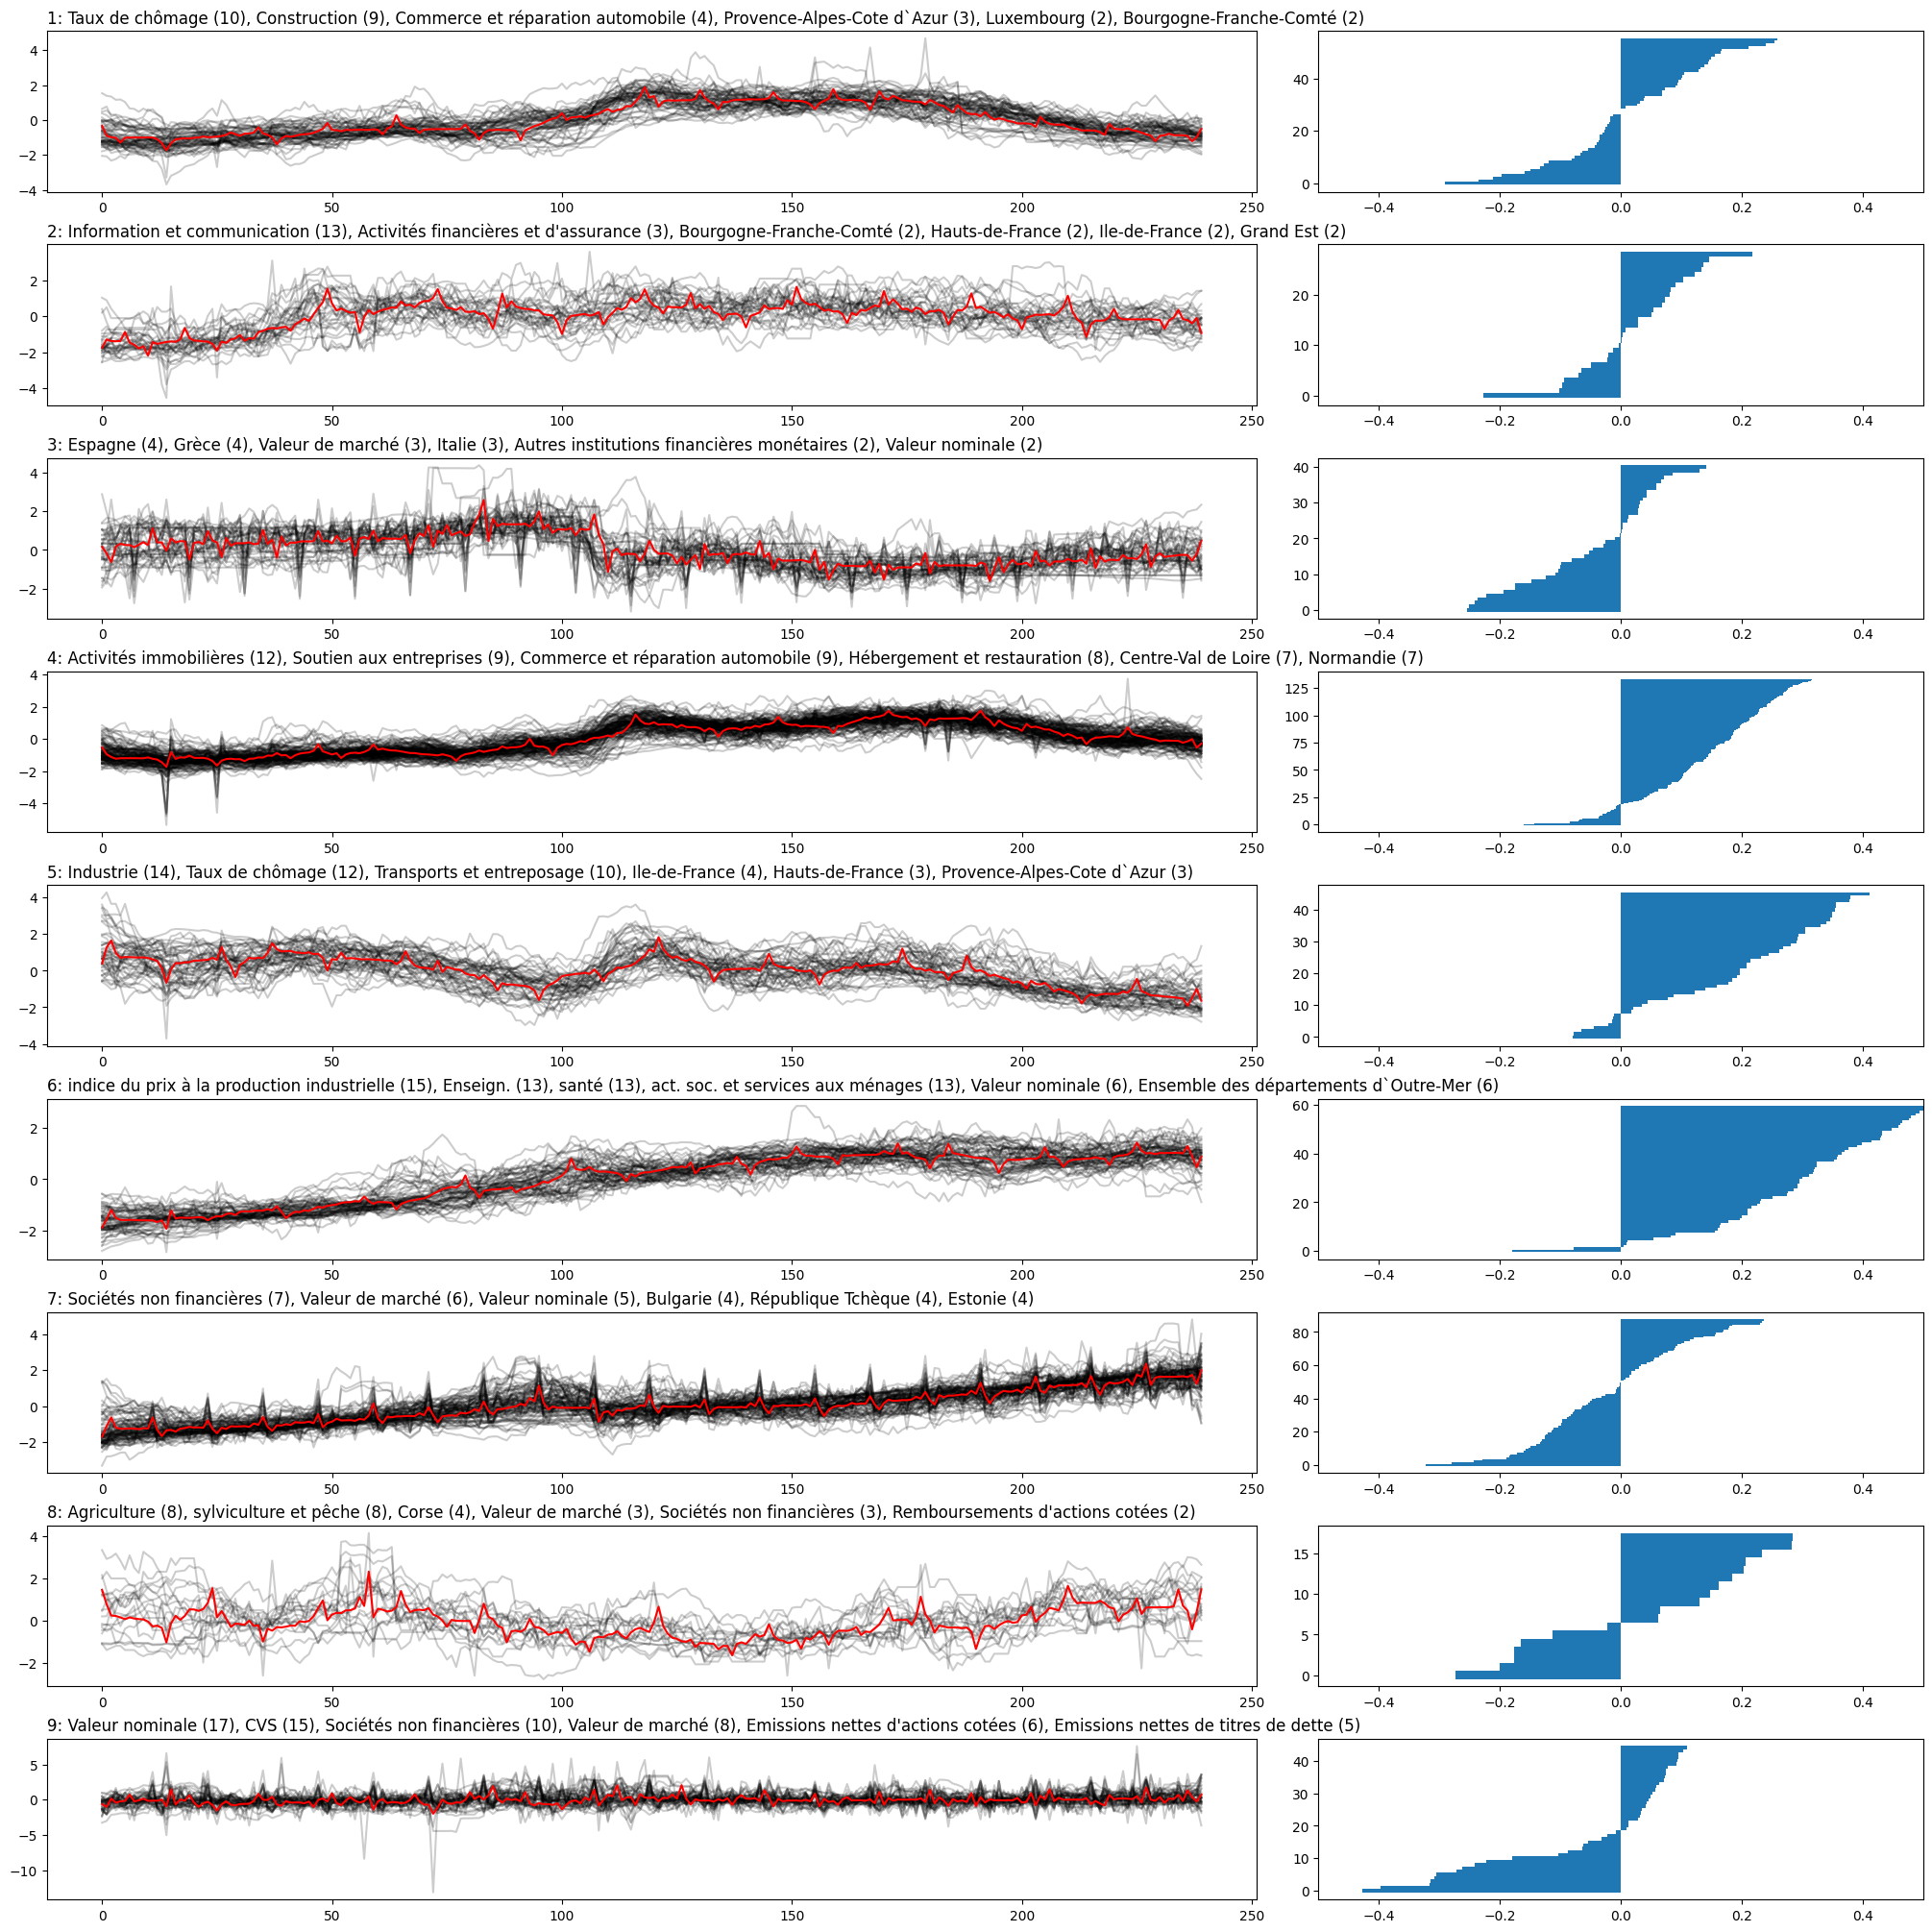

In [85]:
fig, axs = plt.subplots(ncols=2, nrows=CLUSTER_COUNT, figsize=(20,20),
                        layout="constrained", width_ratios=[2,1])

for cluster_index in range(CLUSTER_COUNT):
    first_col = 0

    for xx in X_train[labels == cluster_index]:
        axs[cluster_index, first_col].plot(xx.ravel(), "k-", alpha=0.2)

    axs[cluster_index, first_col].plot(km.cluster_centers_[cluster_index].ravel(), "r-")

    subplot_title = f"{cluster_index + 1}: {df_freq.loc[cluster_index,'series']}"

    axs[cluster_index, first_col].set_title(subplot_title, loc="left")

    second_col = 1
    axs[cluster_index, second_col].barh(y=range(len(silhouettes_scores[labels == cluster_index])),
                                           height=1,
                                           width=sorted(silhouettes_scores[labels == cluster_index]))
        
    axs[cluster_index, second_col].set_xlim(-0.5, 0.5)